### Goal - Extract covariance matrix from systematics file

## 0. Config / Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import uproot
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

In [2]:
COV_DIR = '/exp/sbnd/data/users/brindenc/medulla/test/plots_data_mc4/'
SYST_FILE = '/exp/sbnd/data/users/brindenc/medulla/test/output.root'
CV_MOM_FILE = '/exp/sbnd/data/users/brindenc/medulla/test/plots_data_mc4/reco_leading_muon_momentum_gev.csv'
CV_COSTHETA_FILE = '/exp/sbnd/data/users/brindenc/medulla/test/plots_data_mc4/reco_leading_muon_costheta.csv'
MC_WEIGHT = 6.08 # Ratio of data / MC to get the CV from the MC. We'll have to scale the covariance matrix by this factor.

## 1. Load data

In [3]:
cv_mom_df = pd.read_csv(CV_MOM_FILE)
cv_costheta_df = pd.read_csv(CV_COSTHETA_FILE)

cv_mom_df.columns = ['bin_center','cv']
cv_costheta_df.columns = ['bin_center','cv']

#Scale central values by the weight
cv_mom_df['cv'] /= MC_WEIGHT
cv_costheta_df['cv'] /= MC_WEIGHT


In [4]:
cv_mom_df

,bin_center,cv
0,0.06,45.030153
1,0.18,313.209733
2,0.30,458.306893
3,0.42,465.311584
4,0.54,406.272050
5,0.66,280.187620
6,0.78,239.160147
7,0.90,163.109222
8,1.02,118.079069
9,1.14,84.056286


In [5]:
tree = uproot.open(SYST_FILE)['variations;1']
COSTHETA_BIN_EDGES = tree['reco_leading_muon_costheta_GENIEReWeight_SBN_v1_multisigma_AhtBY_2d;1'].axis(0).edges()
MOM_BIN_EDGES = tree['reco_leading_muon_momentum_GENIEReWeight_SBN_v1_multisigma_AhtBY_2d;1'].axis(0).edges() / 1000. #GeV
COSTHETA_BIN_EDGES,MOM_BIN_EDGES

(array([-1.  , -0.92, -0.84, -0.76, -0.68, -0.6 , -0.52, -0.44, -0.36,
        -0.28, -0.2 , -0.12, -0.04,  0.04,  0.12,  0.2 ,  0.28,  0.36,
         0.44,  0.52,  0.6 ,  0.68,  0.76,  0.84,  0.92,  1.  ]),
 array([0.  , 0.12, 0.24, 0.36, 0.48, 0.6 , 0.72, 0.84, 0.96, 1.08, 1.2 ,
        1.32, 1.44, 1.56, 1.68, 1.8 , 1.92, 2.04, 2.16, 2.28, 2.4 , 2.52,
        2.64, 2.76, 2.88, 3.  ]))

### 1.1 Load weights

In [26]:
tree_weights = uproot.open(SYST_FILE)['events/simulation/multisigmaTree;3']
zexp_ccqe_keys = [k for k in tree_weights.keys() if 'ZExpA' in k]
weight_keys = [k for k in zexp_ccqe_keys if 'nsigma' not in k]
nsigma_keys = [k for k in zexp_ccqe_keys if 'nsigma' in k]
zexp_ccqe_array = tree_weights.arrays(zexp_ccqe_keys,library='pd')

## 2. Functions

In [6]:
def extract_proto_cov(tree, syst_key):
  """
  Extract a proto-covariance matrix from the tree.
  The proto-covariance matrix is a 2D array of shape (n_uni,n_bins)
  where n_univ is the number of universes and n_bin is the number of bins
  in the variable.

  Parameters
  ----------
  tree : uproot.TTree
    The tree to extract the proto-covariance matrix from.
  syst_key : str
    The key of the systematics to extract the proto-covariance matrix from.

  Returns
  -------
  proto_cov : pd.DataFrame
    The proto-covariance matrix. The index is the bin center and the columns
    are the universe IDs. The values are the counts in each bin.
  """
  proto_cov = tree[syst_key].values()
  bin_centers = tree[syst_key].axis(0).centers()
  univ_ids = tree[syst_key].axis(1).centers() - 0.5
  return pd.DataFrame(proto_cov, index=bin_centers, columns=univ_ids)

def extract_cov(proto_cov,cv_df):
  """
  Extract a covariance matrix from a list of proto-covariance matrices.
  
  Parameters
  ----------
  proto_cov : pd.DataFrame
    A dataframe with the bin centers and the proto-covariance matrix.
  cv_df : pd.DataFrame
    A dataframe with the bin centers and the central value of the variable.

  Returns
  -------
  cov : np.ndarray
    The covariance matrix.
  """
  # Convert to numpy arrays for faster computation
  proto_cov_array = proto_cov.values # Shape: (n_bins, n_universes)
  cv_array = cv_df['cv'].values  # Shape: (n_bins,)
  
  # Compute the difference matrix: (n_bins, n_universes)
  diff = proto_cov_array - cv_array[:, np.newaxis]
  
  # Compute covariance using matrix multiplication
  # This is equivalent to: diff @ diff.T / (n_universes - 1)
  cov = (diff @ diff.T) / (proto_cov_array.shape[1])

  return cov

def get_stat_cov(cv_df):
  """
  Get the statistical covariance matrix from the central value dataframe.

  Parameters
  ----------
  cv_df : pd.DataFrame
    A dataframe with the bin centers and the central value of the variable.

  Returns
  -------
  cov : np.ndarray
    The statistical covariance matrix.
  """
  cov = np.zeros((len(cv_df),len(cv_df)))
  for i in range(len(cv_df)):
    cov[i,i] = ((cv_df.iloc[i]['cv']))
  return cov

## 3. All keys

In [7]:
# 2d keys
syst_2d_keys = [k for k in tree.keys() if '_nsigma' not in k and '_2d' in k]

# All keys
syst_mom_keys = [k for k in syst_2d_keys if 'momentum' in k]
syst_costheta_keys = [k for k in syst_2d_keys if 'costheta' in k]

#Flux keys
syst_flux_mom_keys = [k for k in syst_mom_keys if 'Flux' in k]
syst_flux_costheta_keys = [k for k in syst_costheta_keys if 'Flux' in k]

#Xsec multisim keys
syst_xsec_sim_mom_keys = [k for k in syst_mom_keys if 'GENIEReWeight' in k and 'multisim' in k]
syst_xsec_sim_costheta_keys = [k for k in syst_costheta_keys if 'GENIEReWeight' in k and 'multisim' in k]

#Xsec multisigma keys
syst_xsec_sigma_mom_keys = [k for k in syst_mom_keys if 'GENIEReWeight' in k and 'multisigma' in k]
syst_xsec_sigma_costheta_keys = [k for k in syst_costheta_keys if 'GENIEReWeight' in k and 'multisigma' in k]

#Xsec keys
syst_xsec_mom_keys = syst_xsec_sim_mom_keys + syst_xsec_sigma_mom_keys
syst_xsec_costheta_keys = syst_xsec_sim_costheta_keys + syst_xsec_sigma_costheta_keys

all_mom_cov = np.zeros((len(cv_mom_df),len(cv_mom_df)))
all_costheta_cov = np.zeros((len(cv_costheta_df),len(cv_costheta_df)))

flux_mom_cov = np.zeros((len(cv_mom_df),len(cv_mom_df)))
flux_costheta_cov = np.zeros((len(cv_costheta_df),len(cv_costheta_df)))

xsec_sim_mom_cov = np.zeros((len(cv_mom_df),len(cv_mom_df)))
xsec_sim_costheta_cov = np.zeros((len(cv_costheta_df),len(cv_costheta_df)))

xsec_sigma_mom_cov = np.zeros((len(cv_mom_df),len(cv_mom_df)))
xsec_sigma_costheta_cov = np.zeros((len(cv_costheta_df),len(cv_costheta_df)))

xsec_mom_cov = np.zeros((len(cv_mom_df),len(cv_mom_df)))
xsec_costheta_cov = np.zeros((len(cv_costheta_df),len(cv_costheta_df)))

stat_mom_cov = get_stat_cov(cv_mom_df)
stat_costheta_cov = get_stat_cov(cv_costheta_df)

#Store sum of all elements
keys_used_mom = {} 
keys_used_costheta = {}

#Store largest covariance index in dictionary for each key
keys_max = {}

#Store all covariance matrices in a dictionary
cov_dict = {'stat_mom':stat_mom_cov,'stat_costheta':stat_costheta_cov}

for i,key in tqdm(enumerate(tree.keys())):
  if key not in syst_2d_keys:
    continue
  proto_cov = extract_proto_cov(tree,key)
  if key in syst_mom_keys:
    cv_df = cv_mom_df
  else:
    cv_df = cv_costheta_df
  cov = extract_cov(proto_cov,cv_df)
  keys_max[key] = np.unravel_index(np.argmax(cov), cov.shape)
  #Momentum
  if key in syst_mom_keys:
    keys_used_mom[key] = cov.sum()
    if key in syst_flux_mom_keys:
      flux_mom_cov += cov
    if key in syst_xsec_sim_mom_keys:
      xsec_sim_mom_cov += cov
    if key in syst_xsec_sigma_mom_keys:
      xsec_sigma_mom_cov += cov
    if key in syst_xsec_mom_keys:
      xsec_mom_cov += cov
    

  #Costheta
  if key in syst_costheta_keys:
    keys_used_costheta[key] = cov.sum()
    if key in syst_flux_costheta_keys:
      flux_costheta_cov += cov
    if key in syst_xsec_sim_costheta_keys:
      xsec_sim_costheta_cov += cov
    if key in syst_xsec_sigma_costheta_keys:
      xsec_sigma_costheta_cov += cov
    if key in syst_xsec_costheta_keys:
      xsec_costheta_cov += cov
  cov_dict[key] = cov

all_mom_cov = flux_mom_cov + xsec_mom_cov + stat_mom_cov
all_costheta_cov = flux_costheta_cov + xsec_costheta_cov + stat_costheta_cov

# Write the summary covariance matrices to a dictionary
summary_cov_dict = {
  'summary_all_mom':all_mom_cov,
  'summary_all_costheta':all_costheta_cov,
  'summary_flux_mom':flux_mom_cov,
  'summary_flux_costheta':flux_costheta_cov,
  'summary_xsec_mom':xsec_mom_cov,
  'summary_xsec_costheta':xsec_costheta_cov,
  'summary_stat_mom':stat_mom_cov,
  'summary_stat_costheta':stat_costheta_cov,
}

0it [00:00, ?it/s]

364it [00:00, 1124.26it/s]


In [8]:
np.savetxt(f'{COV_DIR}/all_costheta_cov.csv',all_costheta_cov,delimiter=',')
np.savetxt(f'{COV_DIR}/all_mom_cov.csv',all_mom_cov,delimiter=',')
np.savetxt(f'{COV_DIR}/flux_costheta_cov.csv',flux_costheta_cov,delimiter=',')
np.savetxt(f'{COV_DIR}/flux_mom_cov.csv',flux_mom_cov,delimiter=',')
np.savetxt(f'{COV_DIR}/xsec_sim_costheta_cov.csv',xsec_sim_costheta_cov,delimiter=',')
np.savetxt(f'{COV_DIR}/xsec_sim_mom_cov.csv',xsec_sim_mom_cov,delimiter=',')
np.savetxt(f'{COV_DIR}/xsec_sigma_costheta_cov.csv',xsec_sigma_costheta_cov,delimiter=',')
np.savetxt(f'{COV_DIR}/xsec_sigma_mom_cov.csv',xsec_sigma_mom_cov,delimiter=',')
np.savetxt(f'{COV_DIR}/stat_costheta_cov.csv',stat_costheta_cov,delimiter=',')
np.savetxt(f'{COV_DIR}/stat_mom_cov.csv',stat_mom_cov,delimiter=',')

In [9]:
#Find the keys with the largest covariance sum for each variable
sorted_keys = sorted(keys_used_mom.keys(), key=lambda x: keys_used_mom[x], reverse=True)
for key in sorted_keys:
  print(key, keys_used_mom[key])
  break

sorted_keys = sorted(keys_used_costheta.keys(), key=lambda x: keys_used_costheta[x], reverse=True)
for key in sorted_keys:
  print(key, keys_used_costheta[key])
  break

reco_leading_muon_momentum_GENIEReWeight_SBN_v1_multisigma_ZExpA1CCQE_2d;1 223439.86935589754
reco_leading_muon_costheta_GENIEReWeight_SBN_v1_multisigma_ZExpA1CCQE_2d;1 246706.5234124042


/tmp/ipykernel_16924/1936474676.py:1: RuntimeWarning: invalid value encountered in sqrt
  plt.imshow(np.sqrt(all_mom_cov))


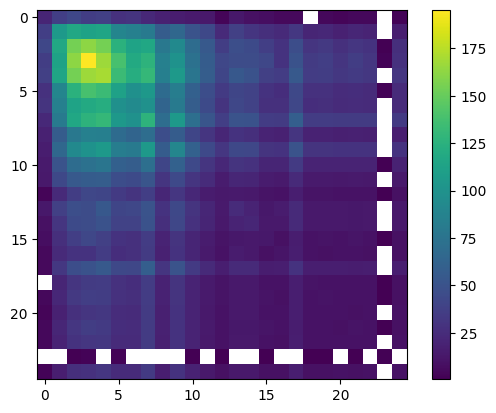

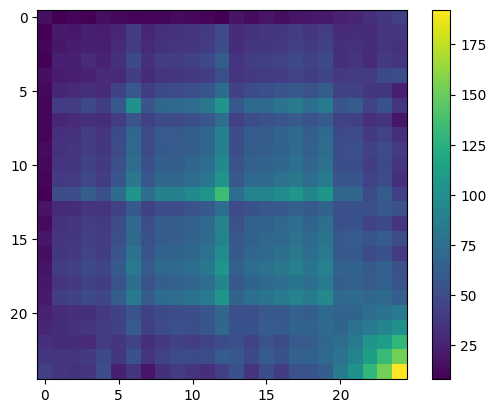

In [10]:
plt.imshow(np.sqrt(all_mom_cov))
plt.colorbar()
plt.show()

plt.imshow(np.sqrt(all_costheta_cov))
plt.colorbar()

## 4. Get fractional uncertainty

In [11]:
import plotters

In [12]:
def get_uncertainty(cov, cv_df, norm=True):
  """
  Get the fractional uncertainty of the covariance matrix.

  Parameters
  ----------
  cov : np.ndarray
    The covariance matrix.
  cv_df : pd.DataFrame
    The dataframe with the central values.
  norm : bool, optional
    Whether to normalize the uncertainty by the central value.

  Returns
  -------
  unc : np.ndarray
    The uncertainty by bin.
  mean_unc : float
    The mean uncertainty.
  """
  frac_unc = np.sqrt(np.diag(cov))
  if norm:
    frac_unc /= cv_df['cv']
    weights = (cv_df['cv'] / np.sum(cv_df['cv']))
    mean_unc = np.sqrt(np.average(frac_unc**2,weights=weights))
  else:
    weights = cv_df['cv']
    mean_unc = np.sqrt(np.average(frac_unc**2,weights=weights))
  return np.array(frac_unc),mean_unc
def extract_parameter_name(key):
    """
    Extract the essential parameter name from a systematic key.
    
    Parameters
    ----------
    key : str
        The full systematic key
        
    Returns
    -------
    str
        The essential parameter name
    """
    #Summary keys are prepended with "summary_"
    if 'summary_' in key:
      return key.replace('summary_', '')
    
    #First check if it's a stat error
    if 'stat' in key:
      return 'Stat'
    
    # Remove the trailing ";1" first
    key = key.replace(';1', '')
    
    # Handle GENIE flux cases
    if 'GENIEReWeight' in key:
        # Pattern: reco_leading_muon_*_GENIEReWeight_SBN_v1_*_2d
        # Extract the parameter name between GENIEReWeight_SBN_v1_ and _2d
        if 'GENIEReWeight_SBN_v1_' in key and '_2d' in key:
            if 'multisigma' in key:
                key_type = 'multisigma_'
            elif 'multisim' in key:
                key_type = 'multisim_'
            start_idx = key.find(f'GENIEReWeight_SBN_v1_{key_type}') + len(f'GENIEReWeight_SBN_v1_{key_type}')
            end_idx = key.find('_2d')
            if start_idx < end_idx:
                return key[start_idx:end_idx]
    
    # Handle regular flux cases (not GENIE)
    if 'Flux' in key and '_2d' in key:
        # Pattern: reco_leading_muon_*_2d
        # Extract the parameter name between reco_leading_muon_ and _2d
        if 'reco_leading_muon_' in key:
            if 'momentum' in key:
                key_type = 'momentum_'
            elif 'costheta' in key:
                key_type = 'costheta_'
            start_idx = key.find(f'reco_leading_muon_{key_type}') + len(f'reco_leading_muon_{key_type}')
            end_idx = key.find('_2d')
            if start_idx < end_idx:
                return key[start_idx:end_idx]
    
    # Split by underscore
    parts = key.split('_')
    
    # Find the parameter name - it's the part before "2d"
    for i, part in enumerate(parts):
        if part == '2d' and 'Flux' not in key:
            if i > 0:
                return parts[i-1]
        elif part == '2d' and 'Flux' in key:
            if i > 0:
                return f'{parts[i-2]}_{parts[i-1]}'
    
    # Fallback: return the last meaningful part
    meaningful_parts = [p for p in parts if p not in ['1', '2d', 'multisigma', 'SBN', 'v1', 'GENIEReWeight']]
    if meaningful_parts:
        return meaningful_parts[-1]
    
    return key

In [13]:
cov_dict.keys()

dict_keys(['stat_mom', 'stat_costheta', 'reco_leading_muon_costheta_GENIEReWeight_SBN_v1_multisigma_ZExpA1CCQE_2d;1', 'reco_leading_muon_costheta_GENIEReWeight_SBN_v1_multisigma_ZExpA2CCQE_2d;1', 'reco_leading_muon_costheta_GENIEReWeight_SBN_v1_multisigma_ZExpA3CCQE_2d;1', 'reco_leading_muon_costheta_GENIEReWeight_SBN_v1_multisigma_ZExpA4CCQE_2d;1', 'reco_leading_muon_costheta_GENIEReWeight_SBN_v1_multisigma_RPA_CCQE_2d;1', 'reco_leading_muon_costheta_GENIEReWeight_SBN_v1_multisigma_CoulombCCQE_2d;1', 'reco_leading_muon_costheta_GENIEReWeight_SBN_v1_multisigma_NormCCMEC_2d;1', 'reco_leading_muon_costheta_GENIEReWeight_SBN_v1_multisigma_NormNCMEC_2d;1', 'reco_leading_muon_costheta_GENIEReWeight_SBN_v1_multisigma_MaNCEL_2d;1', 'reco_leading_muon_costheta_GENIEReWeight_SBN_v1_multisigma_EtaNCEL_2d;1', 'reco_leading_muon_costheta_GENIEReWeight_SBN_v1_multisigma_MaCCRES_2d;1', 'reco_leading_muon_costheta_GENIEReWeight_SBN_v1_multisigma_MvCCRES_2d;1', 'reco_leading_muon_costheta_GENIEReWeigh

In [14]:
def plot_cov_dict(cov_dict, norm=True):
  """
  Plot the fractional uncertainty for each parameter, binned by the central value.

  Parameters
  ----------
  cov_dict : dict
    A dictionary of covariance matrices.
  norm : bool
    If True, normalize the standard deviation by the central value.
  Returns
  -------
  fig : matplotlib.figure.Figure
    A figure containing the momentum plot.
  fig2 : matplotlib.figure.Figure
    A figure containing the costheta plot.
  ax : matplotlib.axes.Axes
    Axes for the momentum plot.
  ax2 : matplotlib.axes.Axes
    Axes for the costheta plot.
  """

  # Do this for all the covariance matrices
  fig,ax = plt.subplots(figsize=(5,5))
  fig2,ax2 = plt.subplots(figsize=(5,5))

  # Collect all data first
  mom_data = []
  costheta_data = []

  for i, (key,cov) in enumerate(cov_dict.items()):
    if 'mom' in key:
      _cv_df = cv_mom_df
      frac_unc,mean_unc = get_uncertainty(cov,_cv_df,norm=norm)
      mom_data.append((key, frac_unc, mean_unc))
    else:
      _cv_df = cv_costheta_df
      frac_unc,mean_unc = get_uncertainty(cov,_cv_df,norm=norm)
      costheta_data.append((key, frac_unc, mean_unc))

  # Sort by mean_unc in descending order
  mom_data.sort(key=lambda x: x[2], reverse=True)
  costheta_data.sort(key=lambda x: x[2], reverse=True)

  # Plot momentum data
  for key, frac_unc, mean_unc in mom_data:
    label = f'{extract_parameter_name(key)} ({mean_unc*100:.2f}%)'
    plotters.plot_hist_edges(MOM_BIN_EDGES,frac_unc,None,label=label,ax=ax)

  # Plot costheta data
  for key, frac_unc, mean_unc in costheta_data:
    label = f'{extract_parameter_name(key)} ({mean_unc*100:.2f}%)'
    plotters.plot_hist_edges(COSTHETA_BIN_EDGES,frac_unc,None,label=label,ax=ax2)

  ylabel = r'Fractional Uncertainty' if norm else r'Standard Deviation'
  if len(cov_dict) > 50: ncol = 5
  else: ncol = 1

  for _ax in [ax,ax2]:
    _ax.set_ylabel(ylabel)
    _ax.legend(ncol=ncol,bbox_to_anchor=(1,1))

  ax.set_xlabel(r'Reconstructed $\mu$ Momentum [GeV/c]')
  ax2.set_xlabel(r'Reconstructed $\cos\theta_\mu$')

  return fig,fig2,ax,ax2

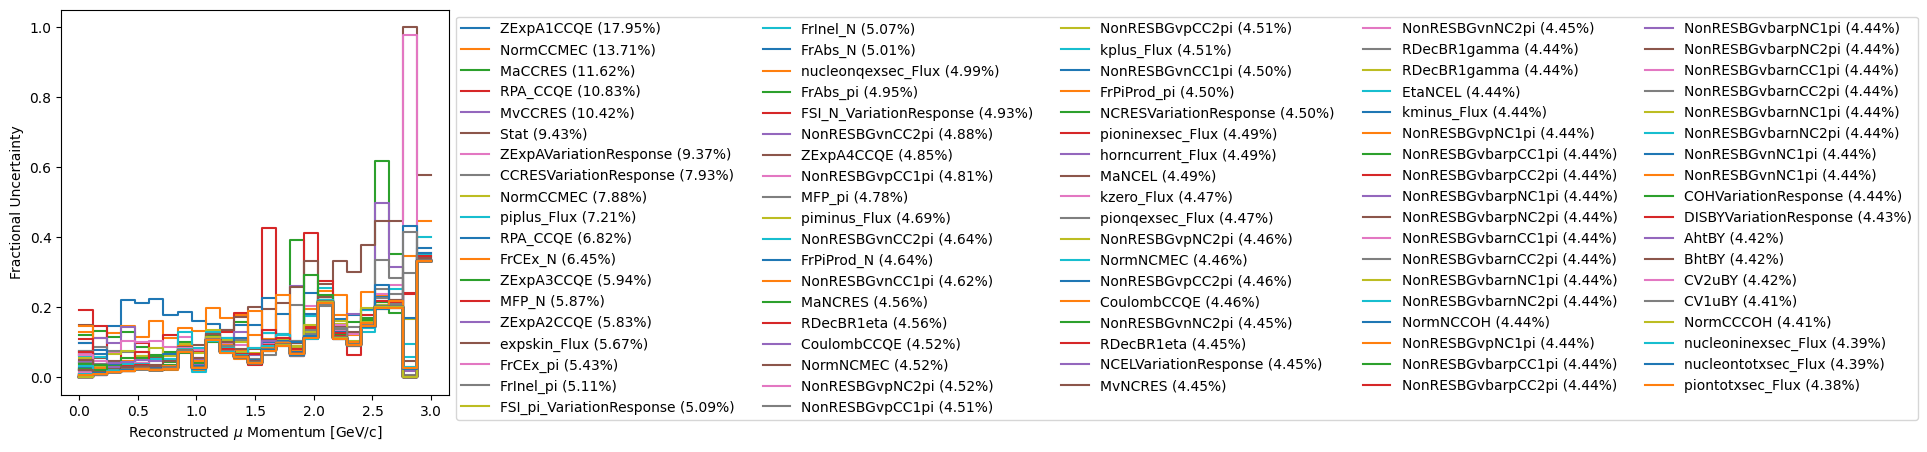

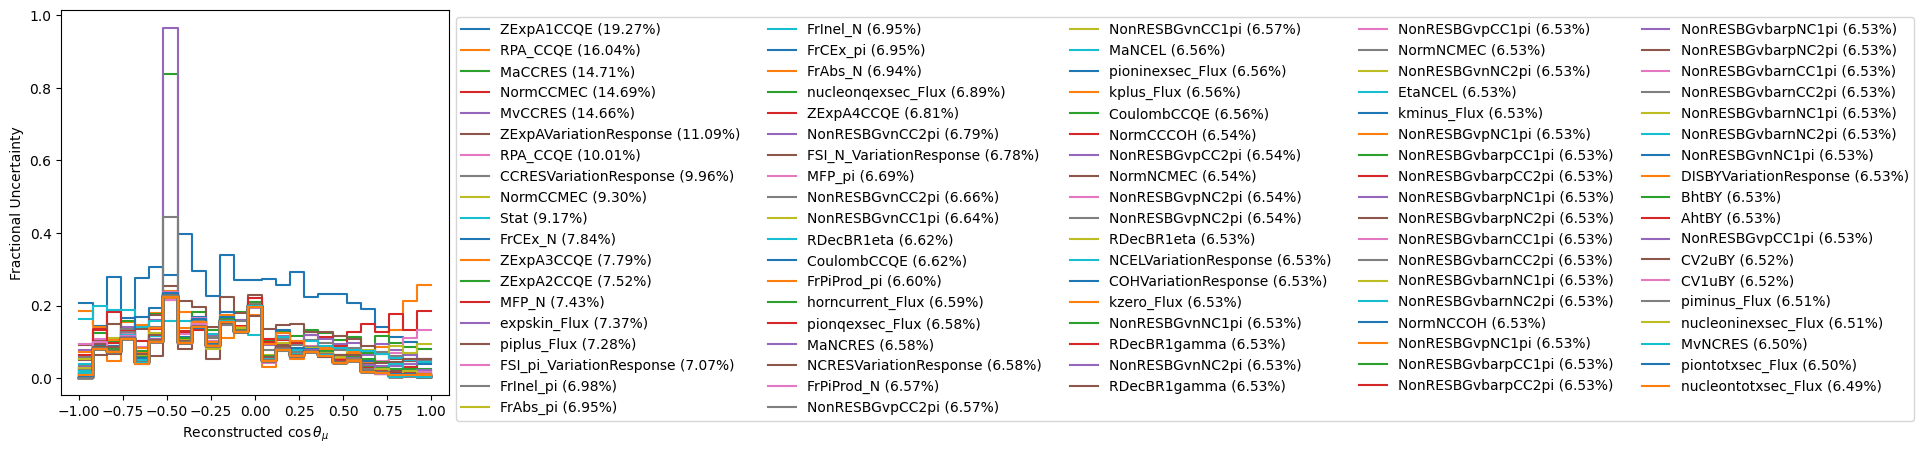

In [15]:
fig,fig2,ax,ax2 = plot_cov_dict(cov_dict)

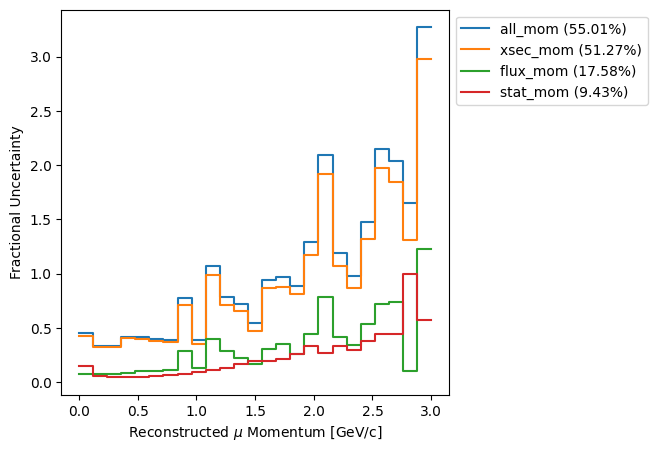

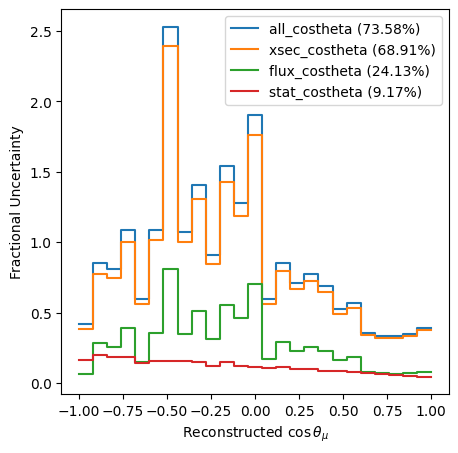

In [16]:
fig,fig2,ax,ax2 = plot_cov_dict(summary_cov_dict,norm=True)

## 4. Single example

In [52]:
syst_flux_costheta_keys

['reco_leading_muon_costheta_expskin_Flux_2d;1',
 'reco_leading_muon_costheta_horncurrent_Flux_2d;1',
 'reco_leading_muon_costheta_kminus_Flux_2d;1',
 'reco_leading_muon_costheta_kplus_Flux_2d;1',
 'reco_leading_muon_costheta_kzero_Flux_2d;1',
 'reco_leading_muon_costheta_nucleoninexsec_Flux_2d;1',
 'reco_leading_muon_costheta_nucleonqexsec_Flux_2d;1',
 'reco_leading_muon_costheta_nucleontotxsec_Flux_2d;1',
 'reco_leading_muon_costheta_piminus_Flux_2d;1',
 'reco_leading_muon_costheta_pioninexsec_Flux_2d;1',
 'reco_leading_muon_costheta_pionqexsec_Flux_2d;1',
 'reco_leading_muon_costheta_piontotxsec_Flux_2d;1',
 'reco_leading_muon_costheta_piplus_Flux_2d;1']

In [250]:
syst_key = 'reco_leading_muon_momentum_GENIEReWeight_SBN_v1_multisigma_ZExpA1CCQE_2d;1'
syst_key2 = 'reco_leading_muon_momentum_nucleontotxsec_Flux_2d;1'
proto_cov = extract_proto_cov(tree, syst_key)
proto_cov2 = extract_proto_cov(tree, syst_key2)

proto_cov.shape,proto_cov2.shape

((25, 6), (25, 1000))

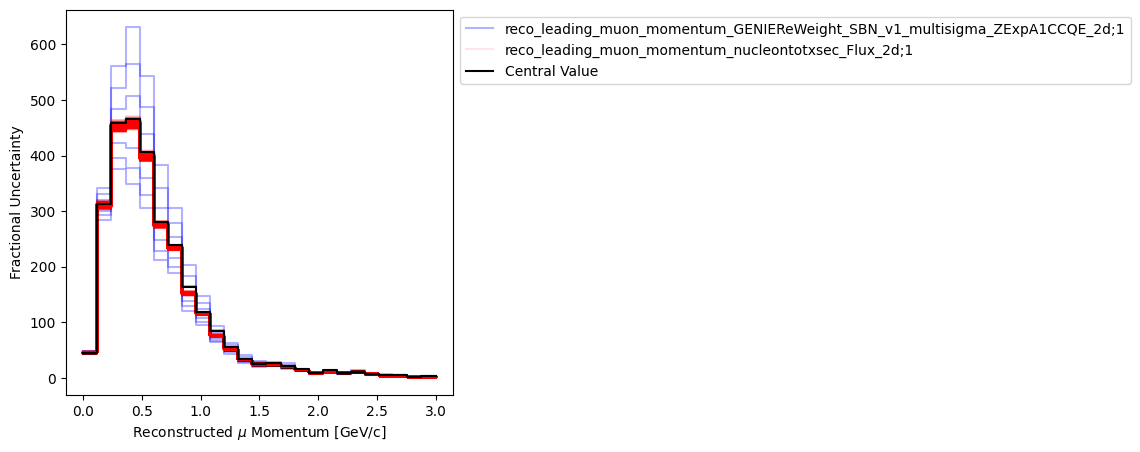

In [255]:
fig,ax = plt.subplots(figsize=(5,5))

for i,univ in enumerate(proto_cov.values.T):
  if i == 0:
    plotters.plot_hist_edges(MOM_BIN_EDGES,univ,None,label=syst_key,ax=ax,alpha=0.3,color='blue')
  else:
    plotters.plot_hist_edges(MOM_BIN_EDGES,univ,None,label=None,ax=ax,alpha=0.3,color='blue')


for i,univ in enumerate(proto_cov2.values.T):
  if i == 0:
    plotters.plot_hist_edges(MOM_BIN_EDGES,univ,None,label=syst_key2,ax=ax,alpha=0.1,color='red')
  else:
    plotters.plot_hist_edges(MOM_BIN_EDGES,univ,None,label=None,ax=ax,alpha=0.1,color='red')
    
plotters.plot_hist_edges(MOM_BIN_EDGES,cv_mom_df['cv'].values,None,label='Central Value',ax=ax,alpha=1,color='black')

ax.set_xlabel(r'Reconstructed $\mu$ Momentum [GeV/c]')
ax.set_ylabel(r'Fractional Uncertainty')
ax.legend(bbox_to_anchor=(1,1))
plt.show()

/tmp/ipykernel_81233/762213522.py:2: RuntimeWarning: invalid value encountered in sqrt
  plt.imshow(np.sqrt(cov))


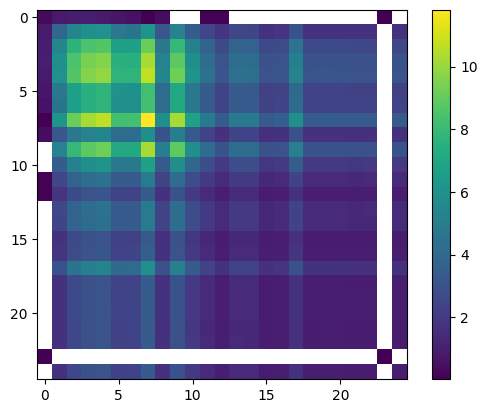

/tmp/ipykernel_81233/762213522.py:6: RuntimeWarning: invalid value encountered in sqrt
  plt.imshow(np.sqrt(extract_cov(proto_cov,cv_mom_df)))


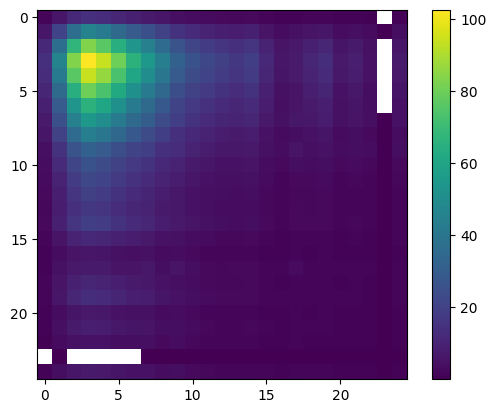

In [259]:
cov = extract_cov(proto_cov2,cv_mom_df)
plt.imshow(np.sqrt(cov))
plt.colorbar()
plt.show()

plt.imshow(np.sqrt(extract_cov(proto_cov,cv_mom_df)))
plt.colorbar()
plt.show()